In [1]:
import numpy as np
import gym
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque, namedtuple
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
cpu_count = os.cpu_count()
print(f"CPU count: {cpu_count}")
torch.set_num_threads(cpu_count)
print(f"PyTorch threads: {torch.get_num_threads()}")
print(f"PyTorch device: {device}")



CPU count: 8
PyTorch threads: 8
PyTorch device: cpu


In [63]:

# Environmental global variables:
SEED = 42

# Making the environment:
env = gym.make('LunarLander-v2')
#env = gym.make('CartPole-v1')
env.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
env.action_space.seed(SEED)  # Ensures deterministic action sampling

# Hyperparameters:
learning_rate = 0.0001
gamma = 0.999
num_episodes = 4000
TAU = 0.01
replay_memory_capacity = int(1e5)
batch_size = 100
MEMORY_SIZE = int(1e5)
frequency_update = 2
MIN_TARGET_ENTROPY = 0.1
DECAY_TARGET_ENTROPY = 0.99998




# Defining the neural network:
space_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(f"Space_dim: {space_dim}, Action_dim: {action_dim}")

class Actor_Model(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor_Model, self).__init__()
        self.seed = torch.manual_seed(SEED)
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, action_size)

    def forward(self, state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        state = F.relu(self.fc3(state))
        state = F.relu(self.fc4(state))
        action_probabilities = F.softmax(self.fc5(state), dim=1)
        return action_probabilities
    
    
class Critic_Model(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic_Model, self).__init__()
        self.seed = torch.manual_seed(SEED)
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64) 
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, action_size)             

    def forward(self, state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        state = F.relu(self.fc3(state))
        state = F.relu(self.fc4(state))
        state_value = self.fc5(state)
        return state_value
    

# Defining the ReplayBuffer
class ReplayBuffer:
    def __init__(self, buffer_size, action_size):
        self.seed = random.seed(SEED)
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.experiences = namedtuple("Experiences", field_names=["state","action","reward","new_state", "done"])
        
    def add(self, state, action, reward, new_state, done):
        e = self.experiences(state, action, reward, new_state, done)
        self.memory.append(e)
        
    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        new_states = torch.from_numpy(np.vstack([e.new_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return states, actions, rewards, new_states, dones
    
    def __len__(self):
        return len(self.memory)
    
class SACAgent:
    def __init__(self, state_size, action_size):
        self.t_step = 0
        self.tau = 0.01
        self.gamma = 0.99
        self.learning_rate = 0.0001
        self.batch_size = 100
        self.num_episodes = 2000

        # SAC Global Params:
        self.init_alpha_entropy = 2
        self.learning_rate_entropy = 0.001

        self.seed = random.seed(SEED)
        self.state_size = state_size
        self.action_size = action_size
        self.update_frequency = 2

        self.memory = ReplayBuffer(buffer_size=int(1e5),action_size=action_size)

        # Actor Network
        self.actor_nn = Actor_Model(state_size=state_size, action_size=action_size).to(device)
        self.optimizer_actor = optim.Adam(self.actor_nn.parameters(), lr=self.learning_rate)

        # Critic Networks
        self.critic1_online_nn = Critic_Model(state_size=state_size, action_size=action_size).to(device)
        self.critic1_target_nn = Critic_Model(state_size=state_size, action_size=action_size).to(device)
        self.optimizer_critic1_local = optim.Adam(self.critic1_online_nn.parameters(), lr=self.learning_rate)

        # Entropy Parameters
        self.target_entropy = 0.98 * -np.log(1 / self.action_size)
        self.alpha_entropy = torch.tensor(np.log(self.init_alpha_entropy), requires_grad=True)
        self.alpha_optimizer = optim.Adam([self.alpha_entropy], lr=self.learning_rate_entropy)  # ALPHA_LR is a small learning rate
        self.mean_entropy = 0        #Just for reporting changes in entropy

        self.update_target_entropy_frequency = 10
        self.min_target_entropy = 0.1
        self.decay_target_entropy = 0.99999

      

    def choose_action(self, state, deterministic=False):

        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action_probs = self.actor_nn(state_tensor)
        if not deterministic:
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample().item()
        else:
            action = torch.argmax(action_probs).item()

        return action, action_probs
    
    
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state=state,action=action, reward=reward,new_state=next_state,done=done)

        self.t_step = (self.t_step + 1) % self.update_frequency
        update_flag = self.t_step == 0
        if update_flag:
            if self.memory.__len__() > self.batch_size:
                experiences = self.memory.sample(batch_size=self.batch_size)
                self.learn(experiences)
                self.update_target_entropy()

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Update the critic networks
        self.update_critic(states, actions, rewards, next_states, dones)

        # Update the actor network
        self.update_actor(states, actions)

        # Update the target networks
        self.soft_update(critic_model_online=self.critic1_online_nn, critic_model_target=self.critic1_target_nn)

        # Update the temperature parameter
        probs = self.actor_nn(states)
        self.update_temperature(probs)


    def update_critic(self, states, actions, rewards, next_states, dones):
        #print(f"\n ======================================== Update Critic ======================================== \n")
        with torch.no_grad():
            next_action_probs = self.actor_nn(next_states)
            next_log_probs = torch.log(next_action_probs + 1e-7)

            q_next = self.critic1_target_nn(next_states)
            q_next_expected = (next_action_probs * (q_next - self.alpha_entropy * next_log_probs)).sum(dim=1, keepdim=True)

            y_target = rewards + self.gamma * (1 - dones) * q_next_expected
            #print(f"Shape of y_target: {y_target.shape}")

        # Step 2: Compute the Q values for the current state
        q_values_current = self.critic1_online_nn(states).gather(1, actions)
        #print(f"Shape of q_values_current: {q_values_current.shape}")
      
        # Compute critic loss
        critic_loss = F.mse_loss(q_values_current, y_target)

        # Update the critic
        self.optimizer_critic1_local.zero_grad()
        critic_loss.backward()
        self.optimizer_critic1_local.step()
        


    def update_actor(self, states, actions):
        #print(f"\n ======================================== Update Actor ======================================== \n")

        probs = self.actor_nn(states)
        log_probs = torch.log(probs + 1e-7)  
        entropy_part = self.alpha_entropy * log_probs
        entropy_part_final = entropy_part.sum(dim=1, keepdim=True)
        #print(f"Entropy Part: {entropy_part_final.mean()}")

        q_values = self.critic1_online_nn(states)
        weighted_q = (probs * q_values).sum(dim=1, keepdim=True)  # Expectation under policy

        actor_loss = (self.alpha_entropy * -log_probs - weighted_q).mean()

        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()


 


    def update_temperature(self, probs):
        # Compute log probabilities of actions
        log_probs = torch.log(probs + 1e-10)
        
        # Compute the current entropy
        entropy = -(probs * log_probs).sum(dim=1, keepdim=True)  # Entropy formula: H(p) = -Σ p(a) log(p(a))

        # Print current entropy vs target entropy
        #print(f"Entropy_mean: {entropy.mean()} vs Target Entropy: {self.target_entropy}")
        self.mean_entropy = entropy.mean()
        
        # Compute the entropy loss for alpha: (entropy - target_entropy) to adjust temperature
        entropy_loss = self.alpha_entropy * (entropy - self.target_entropy).mean()
        
        # Backpropagation for alpha update (temperature)
        self.alpha_optimizer.zero_grad()
        entropy_loss.backward()
        self.alpha_optimizer.step()
        #print(f"Alpha Entropy: {self.alpha_entropy.item()}")


    def update_target_entropy(self):
        #print(f"\n ======================================== Update Target Entropy ======================================== \n")
        
        self.target_entropy = max(self.min_target_entropy,self.target_entropy*self.decay_target_entropy)
            

    
    def soft_update(self, critic_model_online, critic_model_target):
        """
        Apply soft update to the target critic model using the online critic model.
        
        Args:
            self: The current instance of the class (which has critic networks).
            critic_model_online: The online critic model (current model).
            critic_model_target: The target critic model (the one to be updated).
        """
        with torch.no_grad():
            # Apply soft update to the target critic network
            for target_param, online_param in zip(critic_model_target.parameters(), critic_model_online.parameters()):
                target_param.data.copy_((1 - self.tau) * target_param.data + self.tau * online_param.data)


    def load_and_set_weights(self, folder_path=None):
        #logging.info(f" ======================================== Load and Set Weights:{folder_path} ======================================== ")
        foldername = folder_path
        filename_actor = "actor_nn_parameters.pth"
        filename_critic1_online = "critic_local_nn_parameters.pth"
        filename_critic1_target = "critic_target_nn_parameters.pth"

        # Load the actor network parameters
        actor_params = torch.load(f"{foldername}/{filename_actor}")
        self.actor_nn.load_state_dict(actor_params)

        # Load the critic1 online network parameters
        critic1_online_params = torch.load(f"{foldername}/{filename_critic1_online}")
        self.critic1_online_nn.load_state_dict(critic1_online_params)

        # Load the critic1 target network parameters
        critic1_target_params = torch.load(f"{foldername}/{filename_critic1_target}")
        self.critic1_target_nn.load_state_dict(critic1_target_params)


def plot_training(mean_rewards_list, total_rewards_list):
    # Use Seaborn to plot rewards per episode
    sns.set_style("darkgrid")  # Set a nice style
    plt.figure(figsize=(10, 5))  # Set figure size

    sns.lineplot(x=range(len(total_rewards_list)), y=total_rewards_list, label="Total Reward per Episode")
    sns.lineplot(x=range(len(mean_rewards_list)), y=mean_rewards_list, label="Mean Reward (50 episodes)")

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress: Rewards per Episode")
    plt.legend()
    plt.show()

# Making the RL_model
def train_Agent():
  

    
    #print_training_parameters(learning_rate=learning_rate, num_episodes=num_episodes,gamma=gamma, TAU=TAU, SEED=SEED)
    mean_rewards_list = []
    total_rewards_list = []
    best_mean_reward = -np.inf
    total_rewards = 0

    
    #Make the agent
    agent = SACAgent(state_size=space_dim, action_size=action_dim)


    mean_rewards_list = []
    total_rewards_list = []
    best_actions_list = []
    best_states_list = []
    best_episode_rewards_list = []
    best_soc_list = []
    best_mean_reward = -np.inf
    global done_flag
    done_flag = False

    for i_episode in range(agent.num_episodes):
        state = env.reset(seed=SEED)
        actions_list = []
        states_list = []
        episode_rewards_list = []
        soc_list = []
        reward_list = []


        done = False
        episode_rewards = 0
        iter = 0
        #print(f"\n  ---- Episode {i_episode} ----:")

        while not done:
            states_list.append(state)
            #print(f"State: {state}")
            action,_ = agent.choose_action(state=state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)

            state = next_state

            episode_rewards += reward
            iter +=1
      
            episode_rewards_list.append(episode_rewards)
   
            
    
            if done:
                #print(f"Starting information Episode {iter}: Starting balance: {self.env.balance}, Starting Stocks: {self.env.stocks_owned} Total_rewards: {episode_rewards} \n")
                break


        total_rewards_list.append(episode_rewards)
        mean_rewards = np.mean(total_rewards_list[-50:] if len(total_rewards_list) >= 50 else 1)
        mean_rewards_list.append(mean_rewards)

        if i_episode % 10 == 0:
            print(f" Episode: {i_episode}, Total Reward: {episode_rewards}, Mean Reward: {mean_rewards}, Alpha Entropy: {agent.alpha_entropy}, Mean Entropy: {agent.mean_entropy}, Target Entropy: {agent.target_entropy}")
 

        if episode_rewards > best_mean_reward:
            #print(f"Updating at Episode: {i_episode}, Total Reward: {mean_rewards}")
            best_mean_reward = episode_rewards

            
    

    plot_training(mean_rewards_list, total_rewards_list)


Space_dim: 8, Action_dim: 4


 Episode: 0, Total Reward: -173.74563102252938, Mean Reward: 1.0, Alpha Entropy: 0.679158416457939, Mean Entropy: 1.3847990036010742, Target Entropy: 1.3583782866736267
 Episode: 10, Total Reward: -380.3781246482116, Mean Reward: 1.0, Alpha Entropy: 1.2857026269742111, Mean Entropy: 1.1788218021392822, Target Entropy: 1.350941186214681
 Episode: 20, Total Reward: -81.00024289381712, Mean Reward: 1.0, Alpha Entropy: 1.7646304872536271, Mean Entropy: 1.2896596193313599, Target Entropy: 1.3432492549446213
 Episode: 30, Total Reward: -96.74277296355858, Mean Reward: 1.0, Alpha Entropy: 2.319060978096716, Mean Entropy: 1.2231192588806152, Target Entropy: 1.3340260319524126
 Episode: 40, Total Reward: -61.40065056050469, Mean Reward: 1.0, Alpha Entropy: 2.9283125035894115, Mean Entropy: 1.2364617586135864, Target Entropy: 1.324217110233038
 Episode: 50, Total Reward: -460.9516837219733, Mean Reward: -230.24825251699528, Alpha Entropy: 3.270354810073813, Mean Entropy: 1.2919752597808838, Targ

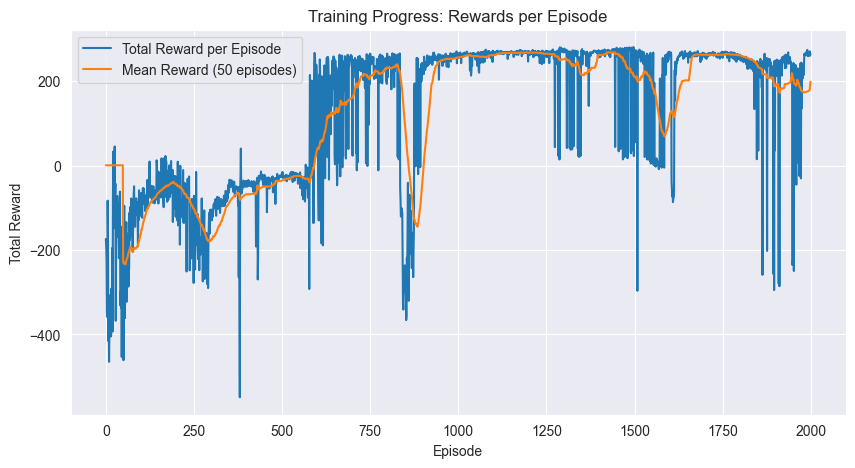

In [64]:
train_Agent()